# System Modeling and Dispatching

This notebook is intended to show a power system modeling framework that exploits the capabilities of Julia to improve performance and allow modelers to develop modular system to analyze problems with different complexities. 

The example system for this notebook is the [Small Test Systems for Power System Economic Studies](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5589973), modified to include 2 PV-Plants and time series of load and renewable energy. The system data can also be accessed in [Matpower format](http://www.pserc.cornell.edu/matpower/docs/ref/matpower5.0/case5.html). 

## 5 - Bus system example

It is possible to store the data for the 5-bus system described in the later sections in terms of the aforementioned type structure. 

The one-line diagram of the system is as follows, where the peak load of each bus is shown: 

![5bus_system](5bus.png)

First the nodes and system parameters are defined in terms of the system and bus types. Which eventually allows for the re-use of the same information is some other components of the system change. 

## Intro
The objecitve is to exploit Julia's integration of dynamic types with the function dispatch. As explained in Julia's documentation: 

"Julia’s type system is dynamic, but gains some of the advantages of static type systems by making it possible to indicate that certain values are of specific types. This can be of great assistance in generating efficient code, but even more significantly, it allows method dispatch on the types of function arguments to be deeply integrated with the language."

The way the types are defined for MEMF is by using immutable types. There are two kinds of composite types (in 0.6) ``struct`` (an immutable type, old name was ``immutable``) and ``mutable struct`` (a mutable type, old name was ``type``). ``mutable struct``s are always allocated on the heap. ``struct``s will be allocated on the stack under certain conditions. (One case where they won't be allocated on the stack right now is if they have a field that is a ``mutable struct``). If a ``struct`` only has e.g. bitstype fields, the ``struct`` should always end up on the stack, and for example an array of such a ``struct`` should have a really nice dense memory layout.

For more details on Julia types, refer to the [documentation](https://docs.julialang.org/en/release-0.6/manual/types/)

## Environment and packages

The examples in this notebook depend upon Julia 1.1 and a specific set of package releases as defined in the `env` folder. Also, the build process of `PowerSystems.jl` retrieves a few sample datafiles that will be used for demonstration. The following steps outline loading the environment, building `PowerSystems.jl`, and loading the required packages.

In [1]:
] activate env; instantiate; st

Activating environment at `~/Documents/repos/Examples/env/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
    Status `~/Documents/repos/Examples/env/Project.toml`
  [5ae59095] Colors v0.9.6
  [41994980] D3TypeTrees v0.1.1
  [a93c6f00] DataFrames v0.19.4
  [e2685f51] ECOS v0.10.0
  [60bf3e95] GLPK v0.11.3
  [b6b21f68] Ipopt v0.6.0
  [4076af6c] JuMP v0.20.0
  [51fcb6bd] NamedColors v0.2.0
  [f0f68f2c] PlotlyJS v0.12.5
  [e690365d] PowerSimulations v0.2.0 #jd/sim_update (https://github.com/NREL/PowerSimulations.jl.git)
  [bcd98974] PowerSystems v0.4.0 #dev (https://github.com/NREL/PowerSystems.jl.git)
  [9e3dc215] TimeSeries v0.16.0
  [0f1e0344] WebIO v0.8.11


In [2]:
# might have to do this the first time after any updates to PowerSystems.jl;
using Pkg
Pkg.build("PowerSystems")

  Building PowerSystems → `~/.julia/packages/PowerSystems/7bCPK/deps/build.log`


false

In [3]:
using PowerSystems;
using PowerSimulations;
using JuMP
using TimeSeries;
using GLPK; 
using DataFrames;
using PlotlyJS;
using D3TypeTrees;
using Plots;

┌ Info: Recompiling stale cache file /Users/cbarrows/.julia/compiled/v1.2/PowerSimulations/ixScC.ji for PowerSimulations [e690365d-45e2-57bb-ac84-44ba829e73c4]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/cbarrows/.julia/compiled/v1.2/PlotlyJS/1r9Ld.ji for PlotlyJS [f0f68f2c-4968-5e81-91da-67840de0976a]
└ @ Base loading.jl:1240


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-2336006356173381750\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-17687762088592766552\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-2336006356173381750\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## Types in PowerSystems

The following trees are made with [D3TypeTrees](https://github.com/claytonpbarrows/D3TypeTrees.jl), nodes that represent Structs will show the Fields in the hoverover tooltip.

In [4]:
fieldnames(System)

(:components, :forecasts, :basepower, :internal, :validation_descriptor)

In [5]:
supertype(PowerSystems.Component)

PowerSystemType

In [6]:
TypeTree(PowerSystems.Component, init_expand=1)

Component
├──Service
│  ├──Reserve
│  │  ├──StaticReserve (0 children)
│  │  └──ProportionalReserve (0 children)
│  └──Transfer
├──Device
│  ├──Branch
│  │  ├──ACBranch (5 children)
│  │  └──DCBranch (2 children)
│  └──Injection
│     ├──Storage (1 children)
│     ├──Generator (3 children)
│     └──ElectricLoad (3 children)
└──PowerSystems.Topology
   ├──LoadZones
   ├──Bus
   └──Arc

In [7]:
TypeTree(PowerSystems.Service)

Service
├──Reserve
│  ├──StaticReserve
│  └──ProportionalReserve
└──Transfer

In [8]:
TypeTree(Forecast)

Forecast
├──ScenarioBased
├──Probabilistic
└──Deterministic

## Load some data

In [9]:
base_dir = joinpath(dirname(dirname(pathof(PowerSystems))),"data")
include(string(base_dir,"/data_5bus_pu.jl"));

In [10]:
sys = System(nodes5, 
            [thermal_generators5; renewable_generators5], 
            loads5, 
            branches5, 
            nothing, 
            230.0, 
            nothing, 
            nothing, 
            nothing);
add_forecasts!(sys,[load_forecast_DA; ren_forecast_DA])
print(summary(sys))

System
Base Power: 230.0

Components
5×3 DataFrame
│ Row │ ConcreteType      │ SuperTypes                                                                               │ Count │
│     │ String            │ String                                                                                   │ Int64 │
├─────┼───────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┼───────┤
│ 1   │ Bus               │ Topology <: Component <: PowerSystemType <: Any                                          │ 5     │
│ 2   │ Line              │ ACBranch <: Branch <: Device <: Component <: PowerSystemType <: Any                      │ 6     │
│ 3   │ PowerLoad         │ StaticLoad <: ElectricLoad <: Injection <: Device <: Component <: PowerSystemType <: Any │ 3     │
│ 4   │ RenewableDispatch │ RenewableGen <: Generator <: Injection <: Device <: Component <: PowerSystemType <: Any  │ 3     │
│ 5   │ ThermalStandard   │ ThermalGen <: Generator <: Injec

## Information about the nodes

The node structure include both topological information and device information. 

```Julia 
using PowerSystems
Node_direct = Bus(1,"nodeA", "PV", 0, 1.0, @NT(min = 0.90, max = 1.1), 230)
```
The node data can be added directly or using named fields. This allows the users to have more clarity when inputing the data. Using named fields, it is possible to only define the minimum fields necessary for the desired analysis. 

For example, in a dispatch problem with not network model, a bus can be specified as follows:

```Julia
Node_dispatch = Bus(number = 1, name = "City")
```

However, if analysis includes an AC Power Flow calculation, then the bus can be specified in much more detail:

```Julia 
Node_acpf = Bus(number = 1, 
                name = "City", 
                bustype = "PV", 
                angle = 0.3, 
                voltage = 0.95, 
                voltagelims = @NT(min = 0.90, max = 1.1))
```

In this more detailed representation of the node, voltage limits are included (```@NT``` stands for Named Tuple). This notation will dissapear with Julia V0.7

The full AC data for the 5-bus system is as follows:

In [11]:
nodes5

5-element Array{Bus,1}:
 Bus(name="nodeA")
 Bus(name="nodeB")
 Bus(name="nodeC")
 Bus(name="nodeD")
 Bus(name="nodeE")

# Information about the Branches and Network

The implementation of the branch data and network explots the use of Julia's abstract types. Both transformers and lines are part of the abstract type Branch. The hierarchy is as follows:

In [12]:
TypeTree(Branch)

Branch
├──ACBranch
│  ├──TapTransformer
│  ├──PhaseShiftingTransformer
│  ├──Transformer2W
│  ├──Line
│  └──MonitoredLine
└──DCBranch
   ├──VSCDCLine
   └──HVDCLine

Any branch is described in terms of its connection points and physical parameters. Where the field ```connectionpoints``` only accepts elements of the type ```Bus``` enforcing consistency between the information. Another feature of this system is the use of abstract types to create collections of type that share the same data structures. 

This representation allows the inclusion of topological information and line characteristics in the same strucutre. For example

```Julia 
Line = Line("1", true, (nodes5[1],nodes5[2]), 0.00281, 0.0281, 0.00712, 400.0, nothing)
```

The implementation of the line structure also uses named fields. It also allows creating lines with less fields. 

```Julia 
Line = Line(name = "LA - San Diego", 
            status = true, 
            (node1, node2), 
            R=0.02, 
            X=0.2, 
            b=0,
            rate = nothing, 
            anglelimits = @NT(min = -10, max = 10)
```

The full AC data for a line between buses A and B with no angle limits is as follows:

In [13]:
branches5[1]

Line:
   name: 1
   available: true
   activepower_flow: 0.0
   reactivepower_flow: 0.0
   arc: Arc
   r: 0.00281
   x: 0.0281
   b: (from = 0.00356, to = 0.00356)
   rate: 2.0
   anglelimits: (min = -0.7, max = 0.7)
   internal: PowerSystems.PowerSystemInternal(UUID("4bb99000-8f41-48ac-8ea5-29f2567dd898"))

The whole system network characteristics are summarizes in the network structure. ```PowerSystems.jl``` uses an inner constructor to calculate the fields relevant for power systems analisys. 

The Network structure has a field for Ybus, Incidence Matrix and PTDF matrix. 

```Julia 
Net5 = Network(FiveBus, branches5, nodes5); 
```


### The PTDF and LODF can be created by passing iterables of `Branch` and `Bus` or a `System` as follows: 

In [14]:
ptdf = PowerSystems.PTDF(sys)

PowerNetworkMatrix
:
  0.193917  -0.348989   0.159538   0.524105  0.0
  0.193917  -0.348989   0.159538  -0.475895  0.0
  0.193917   0.651011   0.159538   0.524105  0.0
  0.437588   0.189451   0.36001    0.258343  0.0
 -0.368495  -0.159538  -0.480452  -0.217552  0.0
  0.368495   0.159538  -0.519548   0.217552  0.0

In [15]:
PowerSystems.LODF(branches5, nodes5)

PowerNetworkMatrix
:
 -1.0        0.344795   0.307071  -1.0       -1.0       -0.307071
  0.542857  -1.0        0.692929   0.542857   0.542857  -0.692929
  0.457143   0.655205  -1.0        0.457143   0.457143   1.0     
 -1.0        0.344795   0.307071  -1.0       -1.0       -0.307071
 -1.0        0.344795   0.307071  -1.0       -1.0       -0.307071
 -0.457143  -0.655205   1.0       -0.457143  -0.457143  -1.0     

# Load Data 

A similar type definition is used for renewable power, storage systems and loads. The main difference in the structures of load and renewable power is the inclusion of a field for time series information of the type ```TimeArray```. This is included considering that in modern power systems analysis for the integration energy sources accounting for the time component of load and generation is paramount.  

Also, type hierarchy can be exploited to represent a larger family of load types:

In [16]:
TypeTree(ElectricLoad)

ElectricLoad
├──ControllableLoad
│  └──InterruptibleLoad
├──FixedAdmittance
└──StaticLoad
   └──PowerLoad

A classic static load is as follows:

```Julia 

Load = StaticLoad("Bus2", true, nodes5[2], "P", 300, 98.61, TimeArray(DayAhead, loadbus2_ts_DA))

```

But it can also be defined with named fields as follows: 

```Julia 
Load = StaticLoad(name = "Denver", 
                  status = true, 
                  bus = nodes5[2], 
                  model = "P", 
                  maxrealpower = 400,  
                  maxreactivepower = 30, 
                  scalingfactor = TimeArray(DayAhead, loadbus2_ts_DA)
```

In the 5-bus cases shown in this notebook, all the loads have been implemented as ```StaticLoads```, further in the notebook the implementation of an interruptible load is shown.

In [17]:
loads5[1]

PowerLoad:
   name: Bus2
   available: true
   bus: Bus(name="nodeB")
   model: ConstantPower
   activepower: 3.0
   reactivepower: 0.9861
   maxactivepower: 3.0
   maxreactivepower: 0.9861
   internal: PowerSystems.PowerSystemInternal(UUID("69f57163-8771-4617-a2cc-6713b7235dc1"))

Using ```TimeArrays``` in Julia enable a whole set of analytical tools relevant to Renewable Energy Integration. It is possible to calculate the percent changes in the time series with the embedded functions. For instance the percent change over the time series.

In [18]:
percentchange(load_forecast_DA[1].data)

23×1 TimeArray{Float64,1,DateTime,Array{Float64,1}} 2024-01-01T01:00:00 to 2024-01-01T23:00:00
│                     │ A       │
├─────────────────────┼─────────┤
│ 2024-01-01T01:00:00 │ -0.0877 │
│ 2024-01-01T02:00:00 │ -0.0169 │
│ 2024-01-01T03:00:00 │ -0.0468 │
│ 2024-01-01T04:00:00 │ -0.0139 │
│ 2024-01-01T05:00:00 │ 0.0051  │
│ 2024-01-01T06:00:00 │ 0.0237  │
│ 2024-01-01T07:00:00 │ 0.0352  │
│ 2024-01-01T08:00:00 │ 0.0625  │
│ 2024-01-01T09:00:00 │ 0.0556  │
│ 2024-01-01T10:00:00 │ 0.0369  │
│ 2024-01-01T11:00:00 │ 0.0151  │
│ 2024-01-01T12:00:00 │ 0.0056  │
│ 2024-01-01T13:00:00 │ -0.0124 │
│ 2024-01-01T14:00:00 │ -0.014  │
│ 2024-01-01T15:00:00 │ -0.0073 │
│ 2024-01-01T16:00:00 │ 0.0087  │
│ 2024-01-01T17:00:00 │ 0.0991  │
│ 2024-01-01T18:00:00 │ 0.093   │
│ 2024-01-01T19:00:00 │ 0.0101  │
│ 2024-01-01T20:00:00 │ -0.0088 │
│ 2024-01-01T21:00:00 │ -0.0307 │
│ 2024-01-01T22:00:00 │ -0.041  │
│ 2024-01-01T23:00:00 │ -0.0917 │

Time Series also can be easily plotted (In the future we expect to have a better way to plot Time Series and Power Systems) 

In [19]:
plot((get_component(load_forecast_DA[1]) |> get_maxactivepower) * values(load_forecast_DA[1].data))

data: [
  "scatter with fields type, x, and y"
]

layout: "layout with field margin"

## Generation Data 

Generators are organized in the data model the three categories:

* **Thermal:** Can represen Coal, Gas, CCGT, Biomass. 
* **Hydro:** Two subtypes Dispatchable, Non Dispatchable. 
* **Renewable:** Fixed Output, Curtailable, Reactive Power Dispatch.  


In [20]:
TypeTree(PowerSystems.Generator)

Generator
├──RenewableGen
│  ├──RenewableDispatch
│  └──RenewableFix
├──HydroGen
│  ├──HydroFix
│  ├──HydroDispatch
│  └──HydroStorage
└──ThermalGen
   └──ThermalStandard

Thermal generators are characterized depending on the type of analysis that is being done. The data is split in technical and economical parameters as follows: 

In [21]:
thermal_generators5[2]

ThermalStandard:
   name: Park City
   available: true
   bus: Bus(name="nodeA")
   activepower: 1.7
   reactivepower: 0.2
   tech: TechThermal(2.2125, PowerSystems.ST, PowerSystems.COAL, (min = 0.0, max = 1.7), (min = -1.275, max = 1.275), (up = 0.02, down = 0.02), (up = 2.0, down = 1.0), PowerSystems.PowerSystemInternal(UUID("f29858c0-b0a9-4fbd-ac47-e182a2d99505")))
   op_cost: ThreePartCost(PowerSystems.VariableCost{Tuple{Float64,Float64}}((0.0, 1500.0)), 0.0, 1.5, 0.75, PowerSystems.PowerSystemInternal(UUID("ffb5ff8b-f322-465c-aa0d-e9b5814cb6cc")))
   internal: PowerSystems.PowerSystemInternal(UUID("ca2a325d-9863-4bc9-8ac0-28a0cfa431d2"))

### Renewable Generation Data

Renewable generation is defined with the same principle as loads, time series is a fundamental component for modern energy integration analysis. In the same fashion as with the branches, the information about the bus is included in the definition of the generator, revealing the explicit topological relashionship of the system

In [22]:
renewable_generators5[1]

RenewableDispatch:
   name: WindBusA
   available: true
   bus: Bus(name="nodeE")
   activepower: 0.0
   reactivepower: 0.0
   tech: TechRenewable(1.2, PowerSystems.WT, nothing, 1.0, PowerSystems.PowerSystemInternal(UUID("78e52c1f-242b-4820-8b60-b8f83790b1cd")))
   op_cost: TwoPartCost(PowerSystems.VariableCost{Float64}(22.0), 0.0, PowerSystems.PowerSystemInternal(UUID("0f82ab9d-811d-4c34-9f32-8d8c48a64b26")))
   internal: PowerSystems.PowerSystemInternal(UUID("add90e20-9047-40c4-881c-1bdaa873d2bf"))

In [23]:
plot((get_component(ren_forecast_DA[1]) |> get_tech |> get_rating) * values(ren_forecast_DA[1].data))

data: [
  "scatter with fields type, x, and y"
]

layout: "layout with field margin"

## Modeling example 

It is possible to use the type structure/schema to build an optimization model. The system parameters are stored in a `SystemParam` type. These parameters include fields that are calculated often such as the number of buses, base voltage, and number of time_periods in the simulation. 

In [24]:
EconomicDispatch = Model()

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.

In [25]:
g_set = [get_name(g) for g in get_components(Generator,sys)]

8-element Array{String,1}:
 "WindBusB" 
 "WindBusC" 
 "WindBusA" 
 "Solitude" 
 "Park City"
 "Alta"     
 "Brighton" 
 "Sundance" 

In [26]:
t_set = 1:get_forecasts_horizon(sys)/8

1.0:1.0:3.0

In [27]:
@variable(EconomicDispatch, Pg[g_set, t = t_set] >=0 )

2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, ["WindBusB", "WindBusC", "WindBusA", "Solitude", "Park City", "Alta", "Brighton", "Sundance"]
    Dimension 2, 1.0:1.0:3.0
And data, a 8×3 Array{VariableRef,2}:
 Pg[WindBusB,1.0]   Pg[WindBusB,2.0]   Pg[WindBusB,3.0] 
 Pg[WindBusC,1.0]   Pg[WindBusC,2.0]   Pg[WindBusC,3.0] 
 Pg[WindBusA,1.0]   Pg[WindBusA,2.0]   Pg[WindBusA,3.0] 
 Pg[Solitude,1.0]   Pg[Solitude,2.0]   Pg[Solitude,3.0] 
 Pg[Park City,1.0]  Pg[Park City,2.0]  Pg[Park City,3.0]
 Pg[Alta,1.0]       Pg[Alta,2.0]       Pg[Alta,3.0]     
 Pg[Brighton,1.0]   Pg[Brighton,2.0]   Pg[Brighton,3.0] 
 Pg[Sundance,1.0]   Pg[Sundance,2.0]   Pg[Sundance,3.0] 

Constraints can be generated individually for the generators indexing using the names and time steps individually

Constraints can be defined in a vectorized way for all the time-steps, however this method has a significant performance impact. For illustrative purposes of using the type structure/schema the upper limit constraints for generator Alta in an Economic Dispatch Model. 

The constraints array can be filled using for loops and it results in a much more efficiente way of creating the model contraints. In this case, since the data for generation contains different generator types besides the conventional thermal

In [28]:
for g in get_components(ThermalGen, sys) # this only adds constraints for the thermal generators. Making more complicated the differentiation with RE
    for t = t_set
        @constraint(EconomicDispatch, Pg[get_name(g),t] <= (get_tech(g) |> get_activepowerlimits).max)
    end
end

Now it is possible to visualize the matrix of constraints populated for the thermal generation. 

In [29]:
EconomicDispatch

A JuMP Model
Feasibility problem with:
Variables: 24
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 15 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 24 constraints
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: Pg

The most effective way to make the addition of constraints and take advantage of parametric dispatch is to define functions with the constraint model relevant for different generators. This is the method to build large scale optimization models in JuMP. 

In [30]:
EconomicDispatch = Model()
@variable(EconomicDispatch, Pg[g_set, t = t_set] >=0 )

2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, ["WindBusB", "WindBusC", "WindBusA", "Solitude", "Park City", "Alta", "Brighton", "Sundance"]
    Dimension 2, 1.0:1.0:3.0
And data, a 8×3 Array{VariableRef,2}:
 Pg[WindBusB,1.0]   Pg[WindBusB,2.0]   Pg[WindBusB,3.0] 
 Pg[WindBusC,1.0]   Pg[WindBusC,2.0]   Pg[WindBusC,3.0] 
 Pg[WindBusA,1.0]   Pg[WindBusA,2.0]   Pg[WindBusA,3.0] 
 Pg[Solitude,1.0]   Pg[Solitude,2.0]   Pg[Solitude,3.0] 
 Pg[Park City,1.0]  Pg[Park City,2.0]  Pg[Park City,3.0]
 Pg[Alta,1.0]       Pg[Alta,2.0]       Pg[Alta,3.0]     
 Pg[Brighton,1.0]   Pg[Brighton,2.0]   Pg[Brighton,3.0] 
 Pg[Sundance,1.0]   Pg[Sundance,2.0]   Pg[Sundance,3.0] 

In [39]:
function powerconstraints(m, P_g, Generator::ThermalGen)
    for var in P_g
        @constraint(m, var >= (get_tech(Generator) |> get_activepowerlimits).min)
        @constraint(m, var <= (get_tech(Generator) |> get_activepowerlimits).max)
    end
end

function powerconstraints(m, P_g, Generator::RenewableGen)
    initial_time = get_forecast_initial_times(sys)[1]
    fc = get_forecasts(Deterministic, sys, initial_time, [Generator])[1] #this makes some assumptions
    for (time, var) in enumerate(P_g)
        @constraint(m, var <= (get_tech(Generator) |> get_rating)*values(fc.data)[time])
    end
end

powerconstraints (generic function with 2 methods)

In [40]:
for (ix, name) in enumerate(Pg.axes[1])
    g = get_components_by_name(Generator, sys, name)
    @assert length(g) == 1
    powerconstraints(EconomicDispatch, Pg[name,:], g[1])
end

In [41]:
# For now, the only object that is in the object dict is the Pg. the Pmax and Pmin objects are in the model, but not in the ob_dict. PowerSimulations will make this more straghtforward
EconomicDispatch.obj_dict

Dict{Symbol,Any} with 1 entry:
  :Pg => 2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:…

In [65]:
c = []
for g in get_components(Generator,sys)
    cost = get_op_cost(g) |> get_variable
    push!(c, cost[length(cost)] * Pg[get_name(g)])
end
@objective(EconomicDispatch,Min,sum(c))

22 Pg[WindBusB,1.0] + 22 Pg[WindBusC,1.0] + 22 Pg[WindBusA,1.0] + 3000 Pg[Solitude,1.0] + 1500 Pg[Park City,1.0] + 1400 Pg[Alta,1.0] + 1000 Pg[Brighton,1.0] + 4000 Pg[Sundance,1.0]

In [66]:
EconomicDispatch

A JuMP Model
Minimization problem with:
Variables: 24
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.GreaterThan{Float64}`: 21 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 30 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 24 constraints
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: Pg

In [67]:
optimize!(EconomicDispatch,with_optimizer(GLPK.Optimizer))

In [68]:
EconomicDispatch.moi_backend.state

ATTACHED_OPTIMIZER::CachingOptimizerState = 2

In [69]:
JuMP.primal_status(EconomicDispatch)

FEASIBLE_POINT::ResultStatusCode = 1

In [70]:
JuMP.value(Pg["Alta",1])

0.0

In [71]:
EconomicDispatch.obj_dict

Dict{Symbol,Any} with 1 entry:
  :Pg => 2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:…

# PowerSimulations.jl makes this easier

[PowerSimulations.jl](https://github.com/nrel/powersimulations.jl) provides access to optimal scheduling formulations for devices in a `PowerSystem`. A number of different formulations are enabled by the `AbstractDeviceFormulation` type tree:

In [72]:
TypeTree(PowerSimulations.AbstractDeviceFormulation,scopesep="\n")

PowerSimulations
AbstractDeviceFormulation
├──PowerSimulations
│  AbstractThermalFormulation
│  ├──ThermalUnitCommitment
│  ├──PowerSimulations
│  │  AbstractThermalDispatchForm
│  │  ├──ThermalDispatchNoMin (0 children)
│  │  ├──ThermalDispatch (0 children)
│  │  └──ThermalRampLimited (0 children)
│  └──PowerSimulations
│     ThermalBasicUnitCommitment
├──PowerSimulations
│  AbstractBranchFormulation
│  ├──PowerSimulations
│  │  AbstractTransformerForm
│  │  ├──PowerSimulations
│  │  │  PhaseControl (0 children)
│  │  ├──PowerSimulations
│  │  │  StaticTransformerUnbounded (0 children)
│  │  ├──StaticTransformer (0 children)
│  │  └──TapControl (0 children)
│  ├──PowerSimulations
│  │  AbstractDCLineForm
│  │  ├──HVDCDispatch (0 children)
│  │  ├──HVDCLossless (0 children)
│  │  └──PowerSimulations
│  │     VoltageSourceDC (0 children)
│  └──PowerSimulations
│     AbstractLineForm
│     ├──PowerSimulations
│     │  FlowMonitoredLine (0 children)
│     ├──StaticLine (0 children)
│     └──PowerSimulations
│        StaticLineUnbounded (0 children)
├──PowerSimulations
│  AbstractLoadFormulation
│  ├──PowerSimulations
│  │  AbstractControllablePowerLoadForm
│  │  ├──DispatchablePowerLoad (0 children)
│  │  └──InterruptiblePowerLoad (0 children)
│  └──StaticPowerLoad
├──PowerSimulations
│  AbstractStorageForm
│  ├──BookKeeping
│  └──BookKeepingwReservation
├──PowerSimulations
│  AbstractRenewableFormulation
│  ├──RenewableFixed
│  └──PowerSimulations
│     AbstractRenewableDispatchForm
│     ├──RenewableConstantPowerFactor (0 children)
│     └──RenewableFullDispatch (0 children)
└──PowerSimulations
   AbstractHydroFormulation
   ├──PowerSimulations
   │  AbstractHydroDispatchForm
   │  ├──PowerSimulations
   │  │  HydroDispatchRunOfRiver (0 children)
   │  └──PowerSimulations
   │     HydroDispatchSeasonalFlow (0 children)
   ├──PowerSimulations
   │  HydroCommitmentSeasonalFlow
   ├──HydroFixed
   └──PowerSimulations
      HydroCommitmentRunOfRiver

In addition to the formulaitons enabled under the `AbstractDeviceFormulation`, a deep integration with [PowerModels.jl](https://github.com/lanl-ansi/powermodels.jl) provides access to a wide variety of power network formulations for representing AC power flow.

In [73]:
TypeTree(PowerSimulations.PowerModels.AbstractPowerFormulation,scopesep="\n")

PowerModels
AbstractPowerFormulation
├──PowerModels
│  AbstractBFForm
│  ├──PowerModels
│  │  AbstractBFQPForm
│  │  └──PowerModels
│  │     SOCBFForm (0 children)
│  └──PowerModels
│     AbstractBFConicForm
│     └──PowerModels
│        SOCBFConicForm (0 children)
├──PowerModels
│  AbstractWRForm
│  ├──PowerModels
│  │  QCWRForm
│  │  └──PowerModels
│  │     QCWRTriForm (0 children)
│  └──PowerModels
│     SOCWRForm
├──PowerModels
│  AbstractACPForm
│  └──PowerModels
│     StandardACPForm
├──PowerModels
│  AbstractLPACForm
│  └──PowerModels
│     AbstractLPACCForm
├──PowerModels
│  AbstractACTForm
│  └──PowerModels
│     StandardACTForm
├──PowerModels
│  AbstractACRForm
│  └──PowerModels
│     StandardACRForm
├──PowerModels
│  AbstractConicPowerFormulation
│  ├──PowerModels
│  │  AbstractWRMForm
│  │  └──PowerModels
│  │     SDPWRMForm (1 children)
│  └──PowerModels
│     AbstractWRConicForm
│     └──PowerModels
│        SOCWRConicForm (0 children)
└──PowerModels
   AbstractActivePowerFormulation
   ├──CopperPlatePowerModel
   └──PowerModels
      AbstractDCPForm
      ├──PowerModels
      │  AbstractDCPLLForm (1 children)
      └──PowerModels
         DCPlosslessForm (2 children)

The intent of `PowerSimulations.jl` is to streamline the construction of large scale optimization problems to avoid repetition of work when adding/modifying model details. To that end, several core problem specifications can be constructed and simulated with the following two commands:

In [82]:
## ED Model Ref
branches = Dict{Symbol, DeviceModel}()
services = Dict{Symbol, PowerSimulations.ServiceModel}()
devices = Dict{Symbol, DeviceModel}(:Generators => DeviceModel(PowerSystems.ThermalStandard, PowerSimulations.ThermalDispatch),
                                    :Ren => DeviceModel(PowerSystems.RenewableDispatch, PowerSimulations.RenewableFullDispatch),
                                    :Loads =>  DeviceModel(PowerSystems.PowerLoad, PowerSimulations.StaticPowerLoad)
                                    )
model_ref_ed= ModelReference(CopperPlatePowerModel, devices, branches, services);
struct TestOptModel <: PowerSimulations.AbstractOperationModel end

In [83]:
ED = OperationModel(TestOptModel, model_ref_ed, sys; optimizer = with_optimizer(GLPK.Optimizer))

┌ Info: Building ThermalStandard with ThermalDispatch formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/UMU6S/src/core/build_operations.jl:14
┌ Info: Building RenewableDispatch with RenewableFullDispatch formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/UMU6S/src/core/build_operations.jl:14
┌ Info: Building PowerLoad with StaticPowerLoad formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/UMU6S/src/core/build_operations.jl:14
┌ Info: Building CopperPlatePowerModel network formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/UMU6S/src/core/build_operations.jl:19
┌ Info: Building Objective
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/UMU6S/src/core/build_operations.jl:34


Operation Model


In [84]:
res_5 = solve_op_model!(ED)

Results Model


In [85]:
res_5.variables

Dict{Symbol,DataFrame} with 2 entries:
  :P_ThermalStandard   => 24×5 DataFrame…
  :P_RenewableDispatch => 24×3 DataFrame…

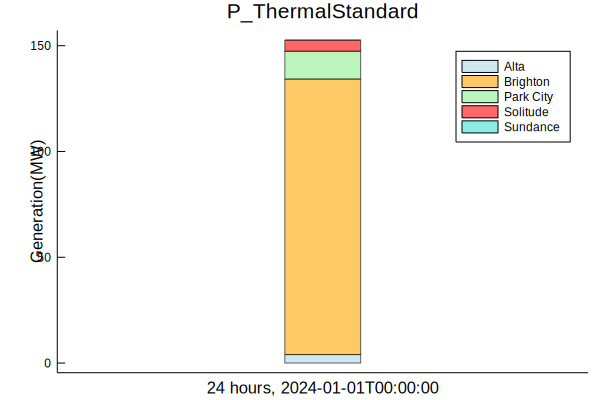

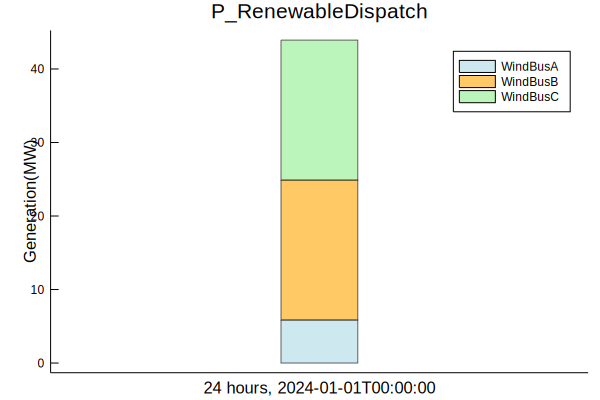

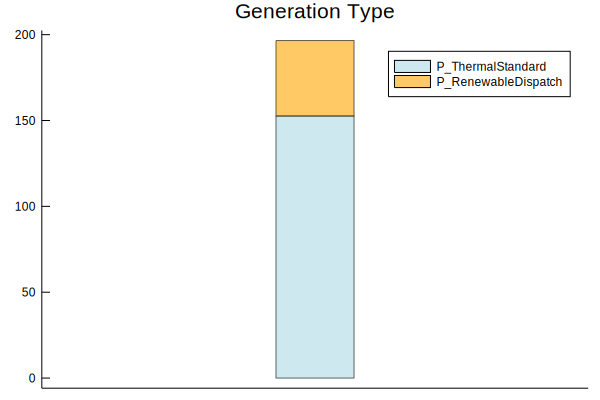

Internal error: encountered unexpected error in runtime:
MethodError(f=typeof(Base.string)(), args=(Expr(:<:, :t, :r),), world=0x0000000000000eec)
rec_backtrace at /Users/sabae/buildbot/worker/package_macos64/build/src/stackwalk.c:94
record_backtrace at /Users/sabae/buildbot/worker/package_macos64/build/src/task.c:219
jl_throw at /Users/sabae/buildbot/worker/package_macos64/build/src/task.c:429
jl_method_error_bare at /Users/sabae/buildbot/worker/package_macos64/build/src/gf.c:1606
jl_method_error at /Users/sabae/buildbot/worker/package_macos64/build/src/gf.c:1624
jl_lookup_generic_ at /Users/sabae/buildbot/worker/package_macos64/build/src/gf.c:2161
jl_apply_generic at /Users/sabae/buildbot/worker/package_macos64/build/src/gf.c:2182
limit_type_size at ./compiler/typelimits.jl:23
jfptr_limit_type_size_4373.clone_1 at /Users/cbarrows/Applications/Julia-1.2.app/Contents/Resources/julia/lib/julia/sys.dylib (unknown line)
abstract_call_method at ./compiler/abstractinterpretation.jl:331
abst

In [92]:
PowerSimulations.bar_plot(res_5)

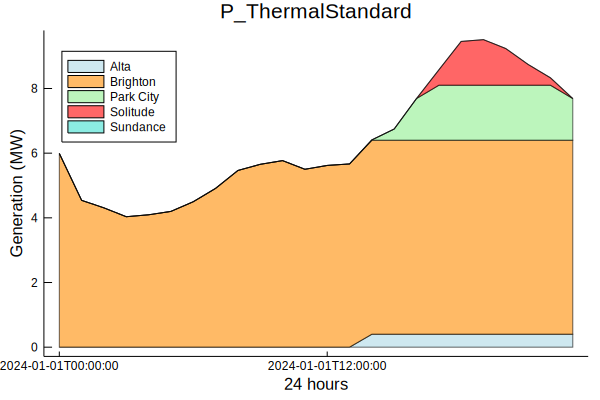

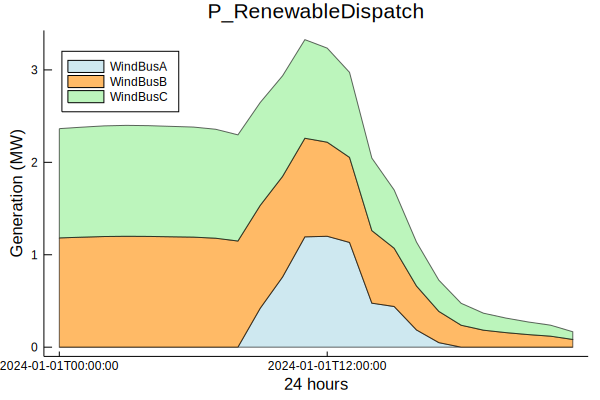

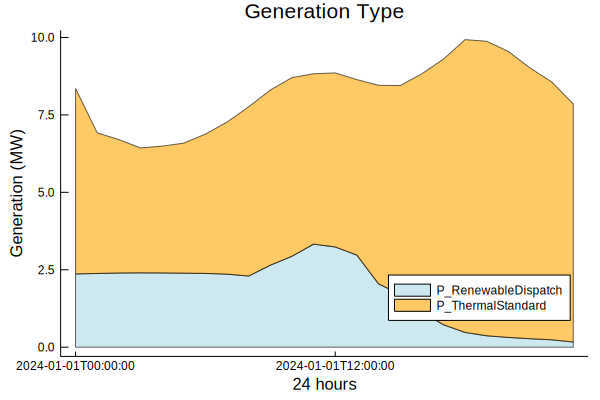

Internal error: encountered unexpected error in runtime:
MethodError(f=typeof(Base.string)(), args=(Expr(:<:, :t, :r),), world=0x0000000000000eec)
rec_backtrace at /Users/sabae/buildbot/worker/package_macos64/build/src/stackwalk.c:94
record_backtrace at /Users/sabae/buildbot/worker/package_macos64/build/src/task.c:219
jl_throw at /Users/sabae/buildbot/worker/package_macos64/build/src/task.c:429
jl_method_error_bare at /Users/sabae/buildbot/worker/package_macos64/build/src/gf.c:1606
jl_method_error at /Users/sabae/buildbot/worker/package_macos64/build/src/gf.c:1624
jl_lookup_generic_ at /Users/sabae/buildbot/worker/package_macos64/build/src/gf.c:2161
jl_apply_generic at /Users/sabae/buildbot/worker/package_macos64/build/src/gf.c:2182
limit_type_size at ./compiler/typelimits.jl:23
jfptr_limit_type_size_4373.clone_1 at /Users/cbarrows/Applications/Julia-1.2.app/Contents/Resources/julia/lib/julia/sys.dylib (unknown line)
abstract_call_method at ./compiler/abstractinterpretation.jl:331
abst

In [93]:
PowerSimulations.stack_plot(res_5)